<a href="https://colab.research.google.com/github/dylanking42/tensorflow-junk/blob/master/Heart_Beat_Classification_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('uploaded "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))


Saving set_a.zip to set_a.zip
uploaded "set_a.zip" with length 85254434 bytes


In [0]:
import wave

In [8]:
import zipfile

archive = zipfile.ZipFile('set_a.zip', 'r')
ff = archive.read('murmur__201108222258.wav')
# a long bytestring with some header info
# that RIFFR substring is important for slicing with WAVE
print(ff[0:20])

b'RIFFR\xae\n\x00WAVEfmt \x10\x00\x00\x00'


In [0]:
archive.printdir() # do we operate on the .wavs or the archives bytestrings?

In [13]:
f = wave.open(archive.open('murmur__201108222258.wav'))
frames = f.readframes(-1)
print(frames[0:20]) # diff bytes, doesn't contain RIFFR / WAVEfmt substrings...

b'\xd1\x01\xf5\x01\n\x02\x1f\x02&\x02\'\x02"\x02\x16\x02\x07\x02\xf8\x01'


In [14]:
# https://www.kaggle.com/kinguistics/loading-and-manipulating-heartbeat-audio
# big thanks to the above link

import struct 
samples = struct.unpack('h'*f.getnframes(), frames)
print(samples[:10])

(465, 501, 522, 543, 550, 551, 546, 534, 519, 504)


In [15]:
framerate = f.getframerate()
t = [float(i)/framerate for i in range(len(samples))]
print(t[:10])

[0.0, 2.2675736961451248e-05, 4.5351473922902495e-05, 6.802721088435374e-05, 9.070294784580499e-05, 0.00011337868480725624, 0.00013605442176870748, 0.00015873015873015873, 0.00018140589569160998, 0.00020408163265306123]


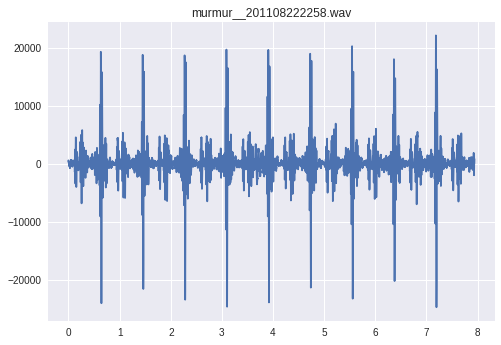

In [21]:
import matplotlib.pyplot as plt
plt.plot(t, samples)
plt.title('murmur__201108222258.wav')
plt.show()

In [32]:
print(len(t))
print(len(samples))

349958
349958


In [33]:
#what happens if we upload a single .wav, will scipy still work?
tu = files.upload()

for fn in tu.keys():
   print('uploaded "{name}" with length {length} bytes'.format(name=fn, length=len(tu[fn])))

wavfile.read('murmur__201108222227.wav')

Saving murmur__201108222227.wav to murmur__201108222227.wav
uploaded "murmur__201108222227.wav" with length 699994 bytes


(44100, array([-2054, -2170, -2224, ...,     3,    -3,    -1], dtype=int16))

In [48]:
# need a func that creates t and samples from each .wav inside the zipfile

# lets try scipy.io

from scipy.io import wavfile

def load_from_zip(fname, zfile):
    z = zipfile.ZipFile(zfile, 'r')
    unzipped_file = z.extract(fname)
    
    # have to use z.extract()
    # z.open() returns bytes, not a file, and scipy.io needs a file, not bytes
    _, data = wavfile.read(unzipped_file)
    return data

data = load_from_zip('murmur__201108222258.wav', 'set_a.zip')  
print(data)

[465 501 522 ... 826 840   4]


In [37]:
# upload our labels and fnames from kaggle csv
label_df = files.upload()

Saving set_a.csv to set_a (1).csv


In [38]:
import pandas as pd
labels = pd.read_csv('set_a (1).csv')
labels.shape

(176, 4)

In [39]:
labels.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


In [40]:
def clean_filename(fname, string):   
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':        
        file_name = string + file_name
    return file_name
  
labels['fname'] = labels['fname'].apply(clean_filename, string='Aunlabelledtest')
labels.head()

,dataset,fname,label,sublabel
0,a,artifact__201012172012.wav,artifact,NaN
1,a,artifact__201105040918.wav,artifact,NaN
2,a,artifact__201105041959.wav,artifact,NaN
3,a,artifact__201105051017.wav,artifact,NaN
4,a,artifact__201105060108.wav,artifact,NaN


In [0]:
labels['label'].fillna('unclassified')

In [49]:
labels['time_series'] = labels['fname'].apply(load_from_zip, zfile='set_a.zip')
labels.head()

,dataset,fname,label,sublabel,time_series
0,a,artifact__201012172012.wav,artifact,NaN,"[1, -3, -1, -7, -9, -2, -6, -5, -3, 4, 2, 4, 2..."
1,a,artifact__201105040918.wav,artifact,NaN,"[-2, 3, -4, 4, -3, 2, -1, 0, 0, 0, 0, 0, 0, -1..."
2,a,artifact__201105041959.wav,artifact,NaN,"[6, -4, -9, -1, -4, 1, -5, 2, 4, 3, 4, 5, 6, -..."
3,a,artifact__201105051017.wav,artifact,NaN,"[-85, -198, -214, -173, -177, -206, -256, -274..."
4,a,artifact__201105060108.wav,artifact,NaN,"[53, -35, 47, 170, 340, 436, 535, 639, 647, 56..."


In [50]:
labels.dtypes

dataset         object
fname           object
label           object
sublabel       float64
time_series     object
dtype: object

In [0]:
# thanks again to https://www.kaggle.com/toregil/what-s-in-a-heartbeat/data
def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

In [55]:
# saved as a string, gotta coerce to another dtype
labels['len_series'] = labels['time_series'].apply(len)
MAX_LEN = max(labels['len_series'])
labels['time_series'] = labels['time_series'].apply(repeat_to_length, length=MAX_LEN)
print(labels.head())
print(labels.dtypes)

  dataset                       fname     label  sublabel  \
0       a  artifact__201012172012.wav  artifact       NaN   
1       a  artifact__201105040918.wav  artifact       NaN   
2       a  artifact__201105041959.wav  artifact       NaN   
3       a  artifact__201105051017.wav  artifact       NaN   
4       a  artifact__201105060108.wav  artifact       NaN   

                                         time_series  len_series  
0  [1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...      396900  
1  [-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...      396900  
2  [6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...      396900  
3  [-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...      396900  
4  [53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...      396900  
dataset         object
fname           object
label           object
sublabel       float64
time_series     object
len_series       int64
dtype: object


In [56]:
x_data = np.stack(labels['time_series'].values, axis=0)
x_data.shape

(176, 396900)

In [57]:
# data type still object ?
x_data[0]

array([ 1., -3., -1., ...,  0.,  1.,  0.], dtype=float32)

In [58]:
from scipy.signal import decimate
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, GlobalAvgPool1D, Dropout, BatchNormalization, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.utils import np_utils
from keras.regularizers import l2

# this is where we will break with toregil, we will use cross validation and the already existing labels
labels.label.unique()

Using TensorFlow backend.


array(['artifact', 'extrahls', 'murmur', 'normal', nan], dtype=object)

In [59]:
labels['label'] = labels['label'].fillna('unclassified')
labels.label.unique()

array(['artifact', 'extrahls', 'murmur', 'normal', 'unclassified'],
      dtype=object)

In [62]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_data = np_utils.to_categorical(le.fit_transform(labels['label'].values))
print(y_data.shape)

(176, 5)


In [63]:
y_data[0:3]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33)
x_train.shape

(117, 396900)

In [0]:
# down sample data
x_train = decimate(x_train, 8, axis=1, zero_phase=True)
x_train = decimate(x_train, 8, axis=1, zero_phase=True)
x_train = decimate(x_train, 4, axis=1, zero_phase=True)
x_test = decimate(x_test, 8, axis=1, zero_phase=True)
x_test = decimate(x_test, 8, axis=1, zero_phase=True)
x_test = decimate(x_test, 4, axis=1, zero_phase=True)

x_train = x_train / np.std(x_train, axis=1).reshape(-1,1)
x_test = x_test / np.std(x_test, axis=1).reshape(-1,1)

x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

In [0]:
# use toregils model as a baseline to see what we get
model = Sequential()
model.add(Conv1D(filters=4, kernel_size=9, activation='relu',
                input_shape = x_train.shape[1:],
                kernel_regularizer = l2(0.025)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=4, kernel_size=9, activation='relu',
                kernel_regularizer = l2(0.05)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=9, activation='relu',
                 kernel_regularizer = l2(0.1)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=9, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.75))
model.add(GlobalAvgPool1D())
model.add(Dense(5, activation='softmax')) # toregil only has 3 classes, but we have 5



In [0]:
def batch_generator(x_train, y_train, batch_size):
    """
    Rotates the time series randomly in time
    """
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    full_idx = range(x_train.shape[0])
    
    while True:
        batch_idx = np.random.choice(full_idx, batch_size)
        x_batch = x_train[batch_idx]
        y_batch = y_train[batch_idx]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch
      
weight_saver = ModelCheckpoint('set_a_weights.h5', monitor='val_loss', 
                               save_best_only=True, save_weights_only=True)

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8**x)

# this is kind of a custom sklearn.kfold thing, but without stratification.
# TODO: rewrite with stratification for equal class representation per batch


In [69]:
hist = model.fit_generator(batch_generator(x_train, y_train, 8),
                   epochs=30, steps_per_epoch=1000,
                   validation_data=(x_test, y_test),
                   callbacks=[weight_saver, annealer],
                   verbose=2)

Epoch 1/30
 - 16s - loss: 2.6701 - acc: 0.2596 - val_loss: 1.9271 - val_acc: 0.3898
Epoch 2/30
 - 13s - loss: 1.8222 - acc: 0.3756 - val_loss: 1.6494 - val_acc: 0.4407
Epoch 3/30
 - 13s - loss: 1.5721 - acc: 0.4029 - val_loss: 1.5090 - val_acc: 0.3898
Epoch 4/30
 - 13s - loss: 1.4527 - acc: 0.4014 - val_loss: 1.4137 - val_acc: 0.3898
Epoch 5/30
 - 13s - loss: 1.3561 - acc: 0.4195 - val_loss: 1.3680 - val_acc: 0.4068
Epoch 6/30
 - 13s - loss: 1.3041 - acc: 0.4332 - val_loss: 1.3241 - val_acc: 0.3729
Epoch 7/30
 - 13s - loss: 1.2707 - acc: 0.4438 - val_loss: 1.3315 - val_acc: 0.3220
Epoch 8/30
 - 12s - loss: 1.2430 - acc: 0.4398 - val_loss: 1.3007 - val_acc: 0.3559
Epoch 9/30
 - 13s - loss: 1.2271 - acc: 0.4574 - val_loss: 1.3101 - val_acc: 0.3220
Epoch 10/30
 - 12s - loss: 1.2152 - acc: 0.4549 - val_loss: 1.3315 - val_acc: 0.3220
Epoch 11/30
 - 13s - loss: 1.2081 - acc: 0.4596 - val_loss: 1.2974 - val_acc: 0.3220
Epoch 12/30
 - 13s - loss: 1.1933 - acc: 0.4617 - val_loss: 1.3148 - val_a

In [70]:
# worse than toregil, but we have more classes and are using default labels
# lets reduce down to 4 classes by combining some labels and check if we should stratify
# notice the diff with acc and val_acc as well. a sign of overfitting
labels['label'].value_counts()

unclassified    52
artifact        40
murmur          34
normal          31
extrahls        19
Name: label, dtype: int64

In [71]:
# after listening to all the extra hls, i feel most of them are artifacts
# we shall label them as such, and run the clasifier again
new_labels = labels['label']
new_labels = new_labels.str.replace('extrahls', 'artifact')
new_labels.value_counts()

artifact        59
unclassified    52
murmur          34
normal          31
Name: label, dtype: int64

In [0]:
y_data = np_utils.to_categorical(le.fit_transform(new_labels.values))
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33)
# down sample data after resplitting
x_train = decimate(x_train, 8, axis=1, zero_phase=True)
x_train = decimate(x_train, 8, axis=1, zero_phase=True)
x_train = decimate(x_train, 4, axis=1, zero_phase=True)
x_test = decimate(x_test, 8, axis=1, zero_phase=True)
x_test = decimate(x_test, 8, axis=1, zero_phase=True)
x_test = decimate(x_test, 4, axis=1, zero_phase=True)

x_train = x_train / np.std(x_train, axis=1).reshape(-1,1)
x_test = x_test / np.std(x_test, axis=1).reshape(-1,1)

x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

In [75]:

model = Sequential()
model.add(Conv1D(filters=4, kernel_size=9, activation='relu',
                input_shape = x_train.shape[1:],
                kernel_regularizer = l2(0.025)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=4, kernel_size=9, activation='relu',
                kernel_regularizer = l2(0.05)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=9, activation='relu',
                 kernel_regularizer = l2(0.1)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=9, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.75))
model.add(GlobalAvgPool1D())
model.add(Dense(4, activation='softmax')) # toregil only has 3 classes, but we have 4 after reclassifying extrahls

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

#reduce epochs, no noticeable change in accuracy after 20
hist = model.fit_generator(batch_generator(x_train, y_train, 8),
                   epochs=20, steps_per_epoch=1000,
                   validation_data=(x_test, y_test),
                   callbacks=[weight_saver, annealer],
                   verbose=2)

Epoch 1/20
 - 19s - loss: 2.5810 - acc: 0.2843 - val_loss: 1.9946 - val_acc: 0.3051
Epoch 2/20
 - 14s - loss: 1.7898 - acc: 0.3712 - val_loss: 1.7036 - val_acc: 0.3559
Epoch 3/20
 - 15s - loss: 1.4974 - acc: 0.4281 - val_loss: 1.5092 - val_acc: 0.4068
Epoch 4/20
 - 15s - loss: 1.3434 - acc: 0.4505 - val_loss: 1.4217 - val_acc: 0.4068
Epoch 5/20
 - 15s - loss: 1.2483 - acc: 0.4620 - val_loss: 1.3722 - val_acc: 0.3729
Epoch 6/20
 - 13s - loss: 1.1947 - acc: 0.4708 - val_loss: 1.3223 - val_acc: 0.3729
Epoch 7/20
 - 13s - loss: 1.1606 - acc: 0.4804 - val_loss: 1.3050 - val_acc: 0.4407
Epoch 8/20
 - 13s - loss: 1.1417 - acc: 0.4856 - val_loss: 1.2847 - val_acc: 0.3729
Epoch 9/20
 - 13s - loss: 1.1380 - acc: 0.4886 - val_loss: 1.2833 - val_acc: 0.4068
Epoch 10/20
 - 13s - loss: 1.1220 - acc: 0.4903 - val_loss: 1.2657 - val_acc: 0.4237
Epoch 11/20
 - 13s - loss: 1.1015 - acc: 0.4883 - val_loss: 1.2833 - val_acc: 0.3898
Epoch 12/20
 - 13s - loss: 1.0937 - acc: 0.4926 - val_loss: 1.2677 - val_a

In [0]:
#significantly better results. just as he said, data quality is key